# Package importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Data import from github

In [2]:
credit_data = pd.read_csv("https://raw.githubusercontent.com/jmoschos/Credit-score-approval/master/credit_record.csv")

In [3]:
app_data = pd.read_csv("https://raw.githubusercontent.com/jmoschos/Credit-score-approval/master/application_record.csv")

# Basic variable inspection

In [4]:
credit_data.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
app_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [6]:
len(app_data)

438557

In [7]:
len(credit_data)

1048575

# Labels 
In the dataset, no labels are given for "good" and "bad" customers. We will attempt to create new labels based on a vintage analysis. 

### Vintage analysis
In vintage analysis, If customer defaults (90 days or more past due) during the performance window, borrower would be considered as a 'bad' customer and labeled as 'event' in dependent variable.

In our dataset, the status is flagged as:
* 0 for 0-29 days
* 1 for 30-59 days
* 2 for 60-89 days
* 3 for 90-119 days
* 4 for 120-149 days
* 5 for 150+ days
* X for no Loan this month
* C for paid this month

If a user has more than 90 days overdue, we are going to flag him as "bad". Therefore, 0,1,2,X,C will be labelled as good and the rest as bad.

First, lets check the distribution amongst different categories:

In [8]:
## Percentage of records per status category
credit_data.groupby(["STATUS"]).agg(percent_per_category = ("STATUS","count"))*100/len(credit_data)

,percent_per_category
STATUS,
0,36.537205
1,1.057626
2,0.082779
3,0.030518
4,0.021267
5,0.161457
C,42.155401
X,19.953747


**Observation**: Majority of users are in the 0, C and X categories. 

Since the user (credit_score) file has multiple observations for each user, we are going to extract the initial month for each user:

In [9]:
# Finding the initial month for each user, as the minimum month in Balance grouped by user
initial_month_df = credit_data.groupby("ID").agg(
    initial_month = ("MONTHS_BALANCE",min)
)

In [37]:
credit_initial = pd.merge(credit_data,initial_month_df,how = "left", on=["ID"])

In [53]:
credit_initial["Label"]= np.where((credit_initial.STATUS == "4") | (credit_initial.STATUS =="5"), 1 , 0 )

In [54]:
credit_initial

,ID,MONTHS_BALANCE,STATUS,initial_month,Label
0,5001711,0,X,-3,0
1,5001711,-1,0,-3,0
2,5001711,-2,0,-3,0
3,5001711,-3,0,-3,0
4,5001712,0,C,-18,0
...,...,...,...,...,...
1048570,5150487,-25,C,-29,0
1048571,5150487,-26,C,-29,0
1048572,5150487,-27,C,-29,0
1048573,5150487,-28,C,-29,0


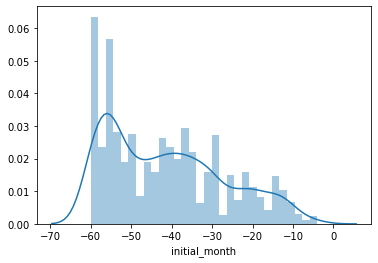

In [58]:
sns.distplot(credit_initial[credit_initial.Label==1].initial_month,bins=30)

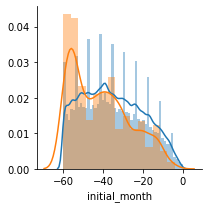

In [61]:
g = sns.FacetGrid(credit_initial, hue = "Label")
g = g.map(sns.distplot, "initial_month")

**Observation** While both the good and bad customers follow similar distributions, we see a huge spike on accounts that are 50 or more months old. These could potentially be test accounts used by the bank for operations.

It might be a good idea to exclude them from the analysis.

In [62]:
out_df =credit_data.groupby(['MONTHS_BALANCE']).agg(
    # Counts
    counts=('MONTHS_BALANCE', lambda x: len(x) ),
    # Percent
    percent = ('MONTHS_BALANCE', lambda x: (len(x)*100/ len(credit_data['MONTHS_BALANCE'])))
    ).reset_index()

In [63]:
out_df

,MONTHS_BALANCE,counts,percent
0,-60,415,0.039578
1,-59,820,0.078201
2,-58,1255,0.119686
3,-57,1649,0.157261
4,-56,2109,0.201130
...,...,...,...
56,-4,33365,3.181937
57,-3,33854,3.228572
58,-2,34209,3.262428
59,-1,34436,3.284076


[]

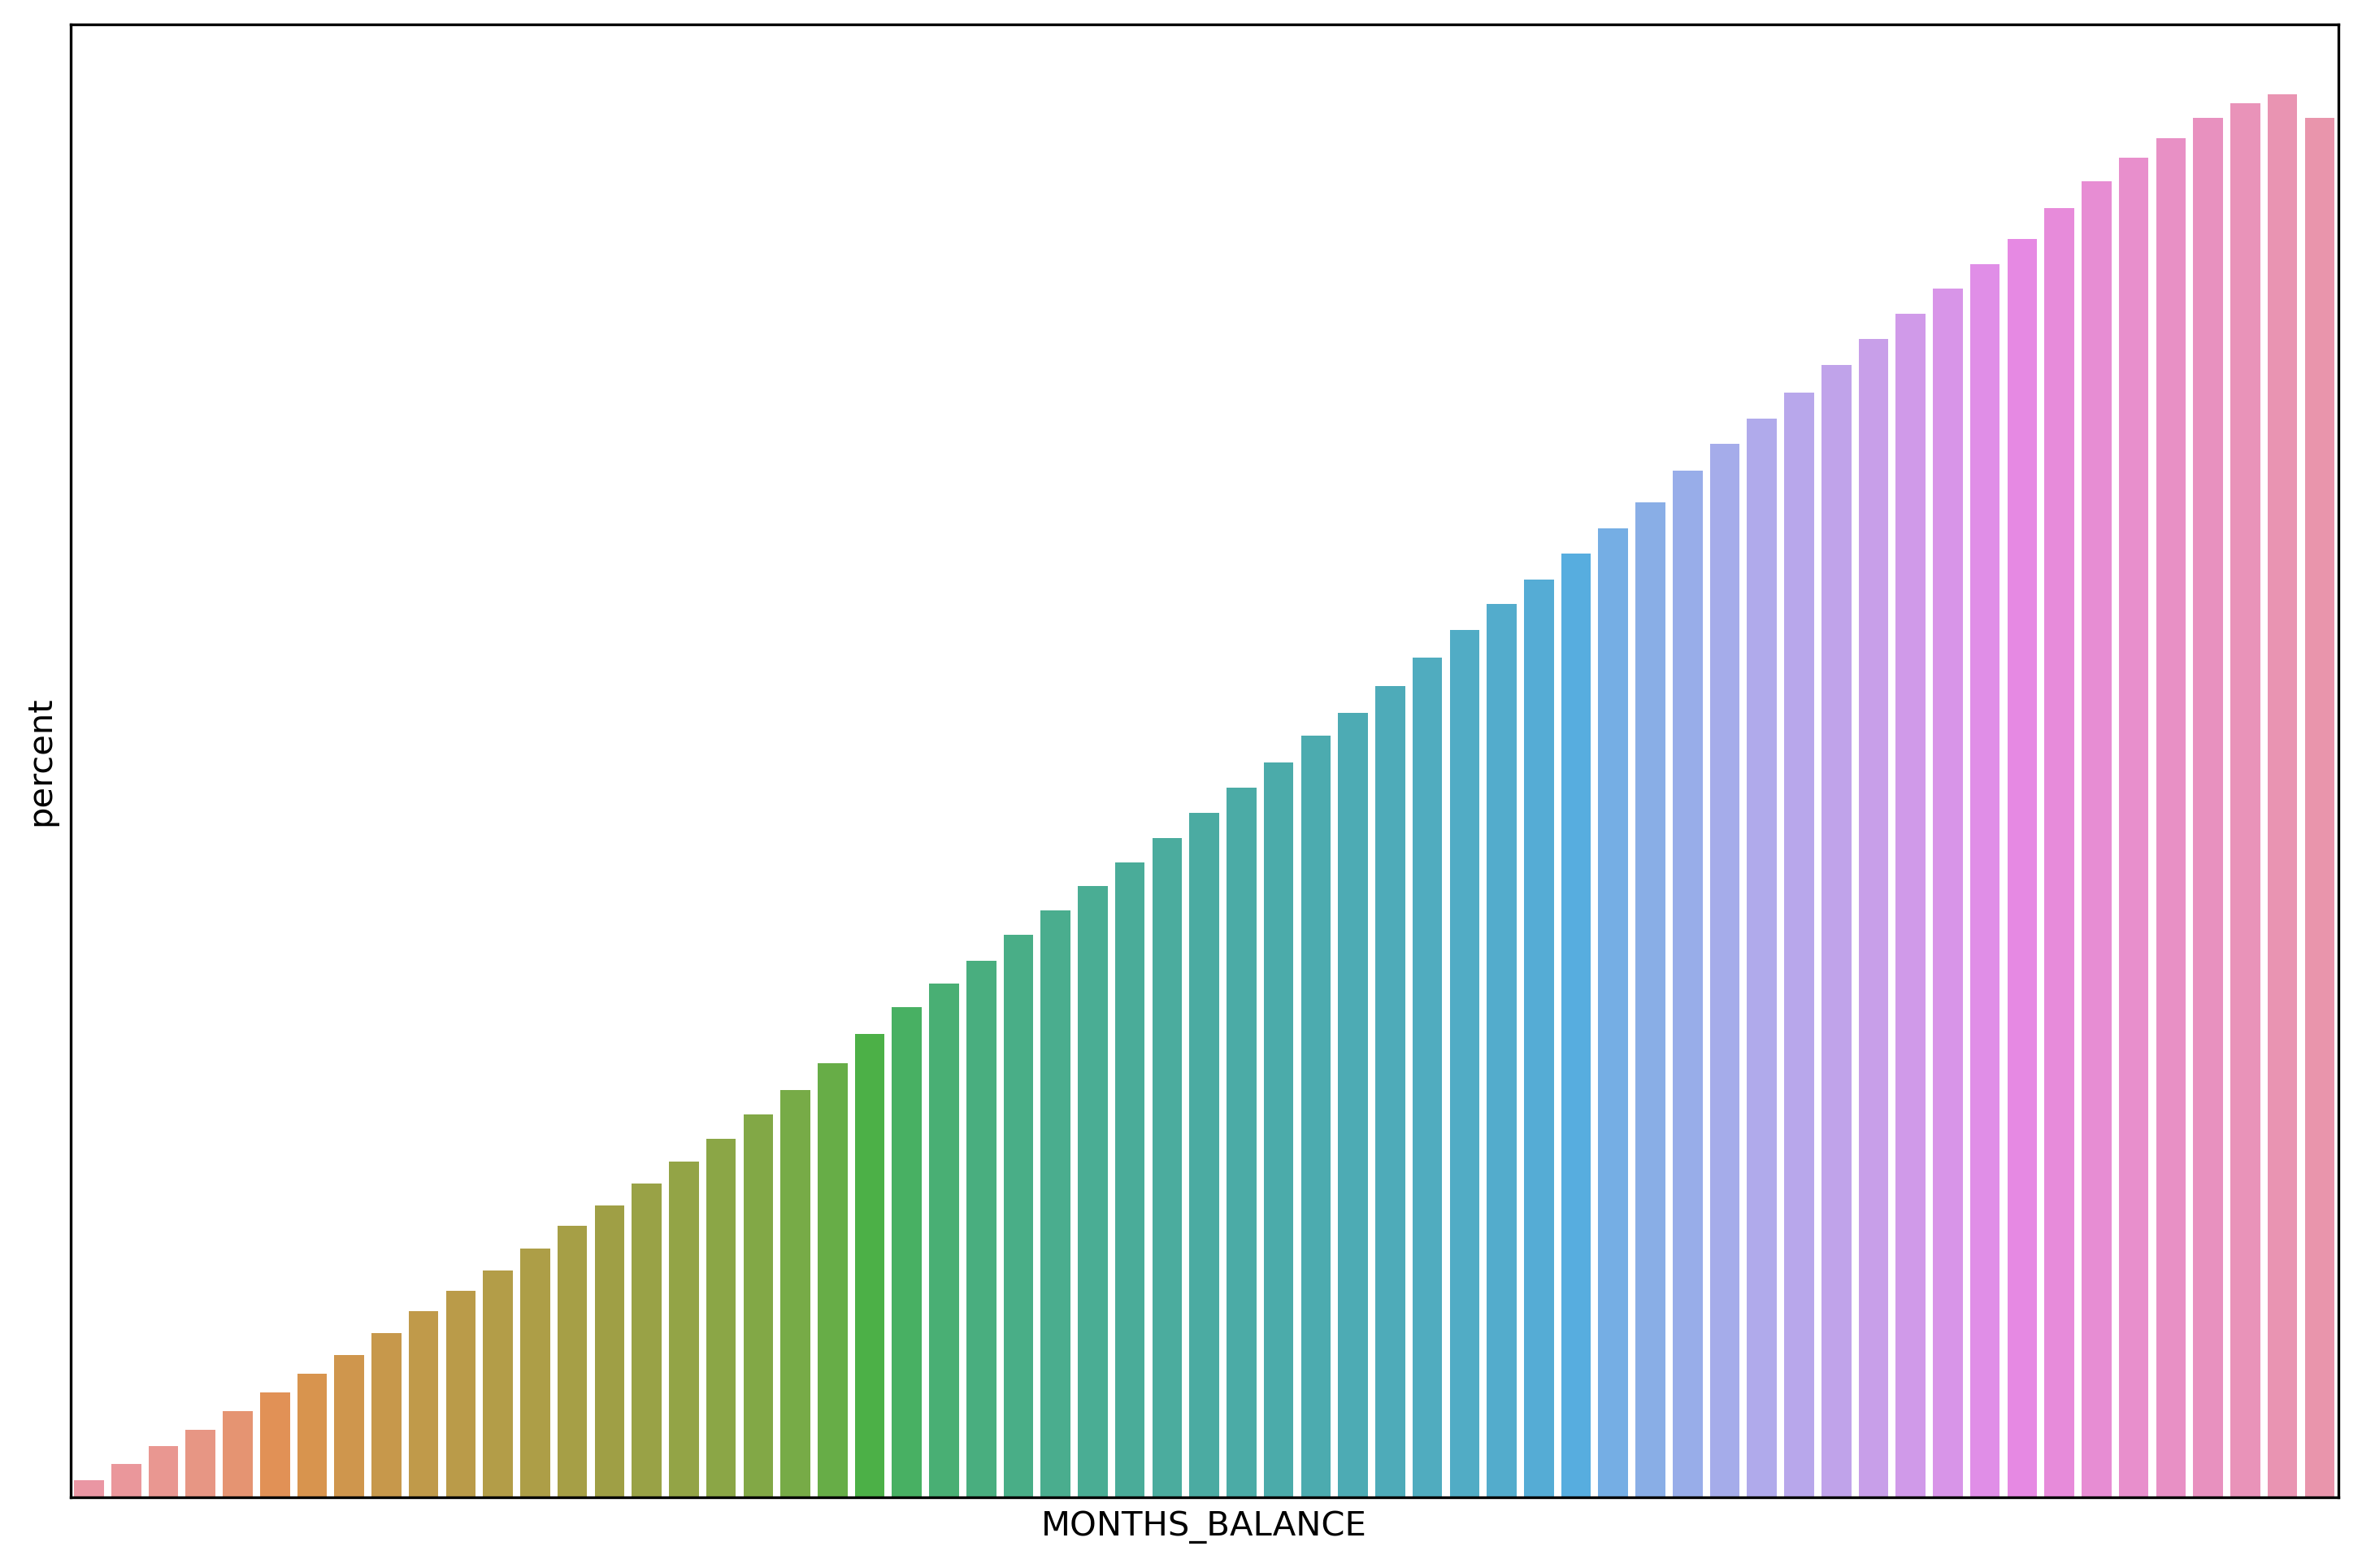

In [71]:
#Extract axes.
fig, ax = plt.subplots(1, 1, figsize = (12, 8), dpi=300)

sns.barplot(x = out_df.MONTHS_BALANCE , y = out_df.percent)
ax.set_yticks([])
ax.set_xticks([])